# Trace simulator experiments

This is a first iteration of the trace simulator.

1. We first start creating a NUMBER_OF_TOWERS towers in a random distribution.
2. Then we generate random traces for NUMBER_OF_USERS users through a number of CYCLES.
3. Finally we aggregate the data, the number of users for each tower in each cycle.

To generate random traces we take into account the distances between the towers and the cycle number (a.k.a. hours)

In [2]:
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Constants

In [3]:
NUMBER_OF_TOWERS = 100
NUMBER_OF_USERS = 100
CYCLES = 24

#
# The probability of jumping to another tower when its
# distance is within one of these distance percentiles.
#
PERCENTILES_PROB = [
    (0.05, 0.75),
    (0.15, 0.125),
    (0.30, 0.09375),
    (1.00, 0.03125),
]

EXPANDER = 1
SIGMA = 0.05

### Generator utils

In [4]:
def distance(p1, p2):
    """Distance between two points"""
    return math.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))

def get_random_trace(distances):
    """Generates an array of length CYCLES
    
    Each element of the returned array represents a tower of a user's trace
    """
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            #
            # For the next tower, the probability changes depending on the distance between
            # the last tower and the others.
            #
            # Also, we take into account the cycle number, so there's always a probability of
            # switching towers or not.
            #
            last_tower = trace[cycle - 1]
            
            # Night vs. Not-night probabilities
            switch_tower_prob = [0.2, 0.8] if cycle in range(0, 7) else [0.5, 0.5]

            if np.random.choice([True, False], p=switch_tower_prob):
                #
                # Get distances of last tower to the rest and
                # prevents the same last_tower from being selected
                #
                last_tower_dist = distances[last_tower].drop(last_tower)

                # Define the distances quantiles for the percentiles defined in the settings
                dist_quantiles = np.array([last_tower_dist.quantile(p) for p, _ in PERCENTILES_PROB])

                # For each distance, determine in which quantile that distance fits
                towers_prob = np.array([
                    PERCENTILES_PROB[np.argmin(d >= dist_quantiles + 0.00001)][1]
                    for d in last_tower_dist
                ])

                #
                # Equally divide the percentile probability
                # by the number of towers that fit in that group.
                #
                # For example, if 5 towers fit in the first percentile (top 5%), and the probability
                # for that group is of 0.25, then each tower has a 0.05 (= 0.25 / 5) chance of
                # being the following tower.
                #
                prob_items, prob_items_counts = np.unique(towers_prob, return_counts=True)
                for prob_item, prob_item_count in zip(prob_items, prob_items_counts):
                    towers_prob[towers_prob == prob_item] /= prob_item_count

                # Select a random tower taking into account the probabilities
                possible_towers_ids = distances.index.drop(last_tower)
                trace.append(np.random.choice(possible_towers_ids, p=towers_prob))
            else:
                trace.append(last_tower)
    
    return trace

def xamtfos(x, sig):
    aux = (1 / (np.sqrt(2 * np.pi * sig ** 2)))
    return -aux * (np.e ** -(x ** 2 / (2 * (sig ** 2)))) + aux + 1

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def generate_probabilities(dists):
#     normalizer = dists.max().max() / 2 * EXPANDER
    """Generate a matrix of probilities to go from """
    for i in range(NUMBER_OF_TOWERS):
        for j in range(NUMBER_OF_TOWERS):
            dists[i][j] = -1 * dists[i][j] * (xamtfos(dists[i][j], SIGMA)) * EXPANDER
    normalizer = dists.max().max() / 2
    dists -= normalizer
    return np.array([softmax(dists[i]) for i in range(NUMBER_OF_TOWERS)])

def generate_weighted_user_trace(probs):
    towers_ids = np.arange(NUMBER_OF_TOWERS)
    
    trace = []
    for cycle in range(CYCLES):
        if cycle == 0:
            # For the first towers the chance of selecting a tower is equally distributed
            trace.append(np.random.choice(towers_ids))
        else:
            last_tower = trace[cycle - 1]
            trace.append(np.random.choice(towers_ids, p=probs[last_tower]))
    
    return trace

def generate_weighted_users_traces(probs):
    return np.array([generate_weighted_user_trace(probs) for _ in range(NUMBER_OF_USERS)])

def generate_user_traces(distances):
    return np.array([get_random_trace(distances) for _ in range(NUMBER_OF_USERS)])

def generate_aggregate_data(traces):
    """Returns how many users were in each step of the cycle based on traces"""
    output = np.zeros((NUMBER_OF_TOWERS, CYCLES))
    for tower in range(NUMBER_OF_TOWERS):
        for user in range(NUMBER_OF_USERS):
            for time in range(CYCLES):
                output[tower][time] += traces[user][time] == tower
    return output

### Generate towers with random positions

In [5]:
towers = np.random.rand(NUMBER_OF_TOWERS, 2)

In [6]:
towers.shape

(100, 2)

### Plot towers positions

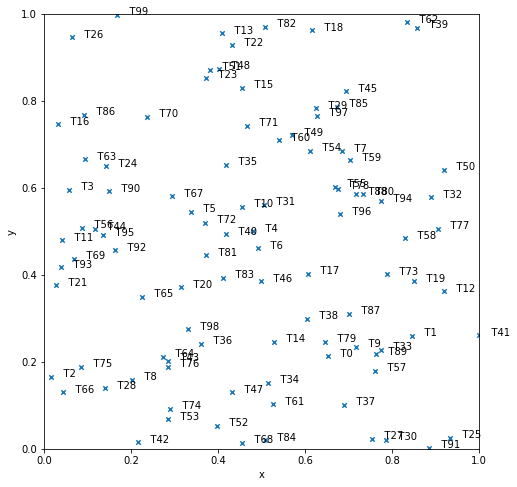

In [7]:
df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(8, 8), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

plt.gca().set_aspect('equal', adjustable='box')

### Calculate the distances between towers for each tower

In [8]:
distances = pd.DataFrame([
    [distance(towers[i], towers[j]) for j in range(NUMBER_OF_TOWERS)] for i in range(NUMBER_OF_TOWERS)
])

### Show example of tower distance probabilities

Distance quantiles: [0.11024119 0.21412046 0.29486683 0.65525996]


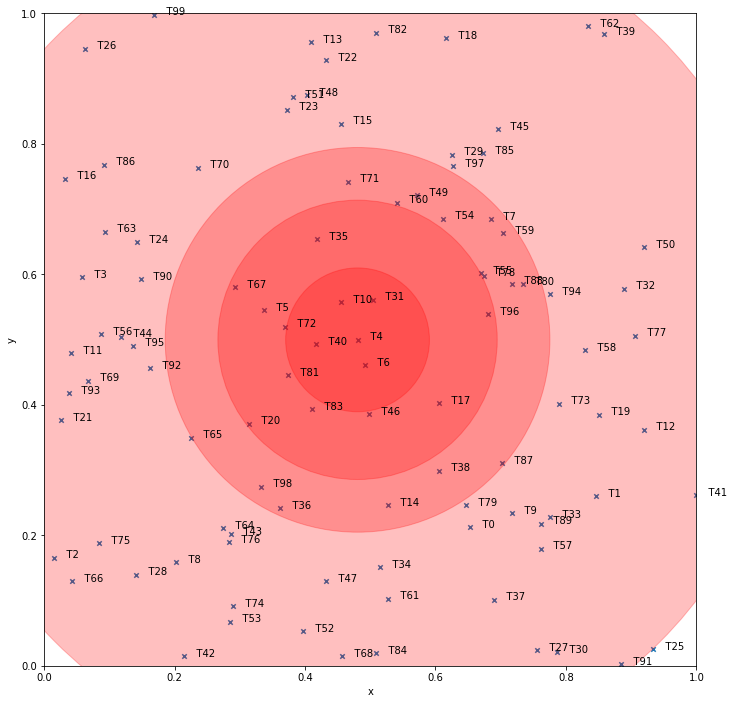

In [9]:
tower_id = 4
tower_dists = distances[tower_id]
dist_quantiles = np.array([tower_dists.quantile(p) for p, _ in PERCENTILES_PROB])
print('Distance quantiles:', dist_quantiles)

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

for r in dist_quantiles:
    ax.add_artist(plt.Circle(towers[tower_id], r, color='r', alpha=1.0 / len(dist_quantiles)))
    
plt.gca().set_aspect('equal', adjustable='box')

## Generate traces based on location and velocity
we will modify the distance matrix to express the jump from one tower to another as a probability using the softmax function

In [10]:
probabilities = generate_probabilities(np.copy(distances.as_matrix()))

In [11]:
probabilities[0].max() == probabilities[0,0]

True

In [12]:
probabilities[0]

array([1.16391779e-01, 1.96716427e-02, 3.72437764e-04, 2.01411300e-04,
       5.72888559e-03, 1.89041436e-03, 8.11582925e-03, 1.66384428e-03,
       1.97678631e-03, 7.88861718e-02, 3.26150981e-03, 2.91534719e-04,
       7.45776075e-03, 1.03457747e-04, 3.74133510e-02, 3.42362574e-04,
       7.39119969e-05, 2.00352854e-02, 1.37738309e-04, 1.10473606e-02,
       4.01637558e-03, 3.46027401e-04, 1.39261683e-04, 2.17560589e-04,
       2.78391553e-04, 5.69057039e-03, 2.47596704e-05, 1.70119911e-02,
       1.11508977e-03, 6.87168677e-04, 1.43041358e-02, 3.86450568e-03,
       2.33999796e-03, 4.06617964e-02, 3.04474916e-02, 1.30679742e-03,
       8.34099382e-03, 4.34467141e-02, 5.32026220e-02, 1.02622531e-04,
       4.31837270e-03, 5.04353288e-03, 1.55407553e-03, 4.28620711e-03,
       4.85598746e-04, 4.80751278e-04, 1.44184822e-02, 1.40141649e-02,
       2.01868003e-04, 1.13296514e-03, 1.24643561e-03, 1.92905030e-04,
       7.75991934e-03, 3.31241818e-03, 1.64095494e-03, 3.50660977e-03,
      

In [13]:
pd.DataFrame(probabilities).describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.011105,0.009513,0.008003,0.009399,0.011376,0.010663,0.011013,0.011175,0.010321,0.011873,...,0.010557,0.008273,0.010632,0.009808,0.010540,0.011443,0.010977,0.011320,0.010802,0.007172
std,0.020533,0.021524,0.029788,0.022184,0.018417,0.018487,0.017413,0.019453,0.022748,0.022935,...,0.021904,0.035387,0.020135,0.025153,0.019975,0.023288,0.017910,0.022017,0.018963,0.038917
min,0.000081,0.000033,0.000009,0.000024,0.000798,0.000238,0.001097,0.000100,0.000028,0.000064,...,0.000048,0.000005,0.000103,0.000045,0.000094,0.000072,0.000226,0.000088,0.000129,0.000004
25%,0.000547,0.000196,0.000082,0.000246,0.002747,0.001918,0.002726,0.000557,0.000243,0.000381,...,0.000483,0.000052,0.000561,0.000193,0.000460,0.000499,0.001031,0.000462,0.001004,0.000057
50%,0.002856,0.000878,0.000390,0.000995,0.004563,0.004343,0.004590,0.002613,0.001171,0.002277,...,0.001904,0.000250,0.002120,0.000957,0.002305,0.001971,0.004242,0.001821,0.003395,0.000311
75%,0.012245,0.006040,0.003116,0.004389,0.009567,0.010396,0.010073,0.011319,0.006826,0.009327,...,0.006702,0.001884,0.010283,0.005901,0.009252,0.007843,0.013173,0.012757,0.011233,0.001231
max,0.116392,0.154446,0.214801,0.150700,0.098775,0.111483,0.102998,0.103722,0.136566,0.109499,...,0.128717,0.256610,0.119108,0.141521,0.116040,0.111182,0.104176,0.110211,0.115051,0.364167


In [14]:
probabilities[2]

array([6.87333252e-04, 1.18422788e-04, 2.14800827e-01, 4.43215101e-03,
       1.25307352e-03, 2.44582067e-03, 1.39721032e-03, 1.06607175e-04,
       3.99522735e-02, 3.81920940e-04, 1.08908968e-03, 1.27094558e-02,
       5.25563833e-05, 7.70045041e-05, 2.03999948e-03, 1.66217959e-04,
       1.15830596e-03, 7.09488124e-04, 2.77363344e-05, 9.19323964e-05,
       8.27325406e-03, 3.21440360e-02, 8.78400921e-05, 2.05539458e-04,
       2.40323828e-03, 5.15517986e-05, 1.91119395e-04, 2.48685388e-04,
       7.05429002e-02, 8.82415700e-05, 1.86558054e-04, 7.54148613e-04,
       3.66836584e-05, 2.29018234e-04, 2.40511603e-03, 7.30533900e-04,
       8.92894896e-03, 4.93413189e-04, 9.40562024e-04, 6.21058315e-06,
       2.03535264e-03, 2.99203112e-05, 2.27470265e-02, 1.85168248e-02,
       8.91567971e-03, 4.42122713e-05, 1.82455606e-03, 4.99848233e-03,
       1.52044233e-04, 1.84631358e-04, 2.21918081e-05, 1.69386602e-04,
       6.02185194e-03, 1.64432823e-02, 1.76026676e-04, 1.84220694e-04,
      

## Generate random user traces

We take into account the distances between towers in order to select the following towers

In [15]:
# %time random_traces = generate_user_traces(distances)
%time random_traces = generate_weighted_users_traces(probabilities)

CPU times: user 76.8 ms, sys: 8.16 ms, total: 85 ms
Wall time: 81 ms


In [16]:
%time aggregated_data = generate_aggregate_data(random_traces)

print(f'Traces shape: {random_traces.shape}\t aggregated_data shape: {aggregated_data.shape}')

CPU times: user 945 ms, sys: 2.05 ms, total: 947 ms
Wall time: 945 ms
Traces shape: (100, 24)	 aggregated_data shape: (100, 24)


In [17]:
random_traces[0]

array([50,  4,  5, 83, 40, 51, 15, 49, 80, 80, 29, 97, 97, 96, 78, 59, 97,
       45, 80, 78, 45, 55, 88, 55])

In [18]:
aggregated_data

array([[1., 1., 0., ..., 1., 2., 1.],
       [0., 2., 2., ..., 1., 0., 2.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 2., 0., ..., 1., 1., 3.],
       [2., 0., 0., ..., 1., 1., 0.],
       [1., 2., 0., ..., 0., 0., 0.]])

In [19]:
# Check that the sum of users at every cycle is the same
all(aggregated_data.sum(axis=0) == NUMBER_OF_USERS)

True

## Draw some random user traces

Cycle #0: Switching from T98 to T76
Cycle #1: Switching from T76 to T38
Cycle #2: Switching from T38 to T78
Cycle #3: Staying in tower T78
Cycle #4: Switching from T78 to T23
Cycle #5: Switching from T23 to T48
Cycle #6: Switching from T48 to T85
Cycle #7: Switching from T85 to T59
Cycle #8: Switching from T59 to T7
Cycle #9: Staying in tower T7
Cycle #10: Switching from T7 to T55
Cycle #11: Switching from T55 to T54
Cycle #12: Staying in tower T54
Cycle #13: Switching from T54 to T5
Cycle #14: Switching from T5 to T93
Cycle #15: Staying in tower T93
Cycle #16: Staying in tower T93
Cycle #17: Switching from T93 to T90
Cycle #18: Switching from T90 to T3
Cycle #19: Switching from T3 to T90
Cycle #20: Switching from T90 to T21
Cycle #21: Switching from T21 to T93
Cycle #22: Switching from T93 to T56


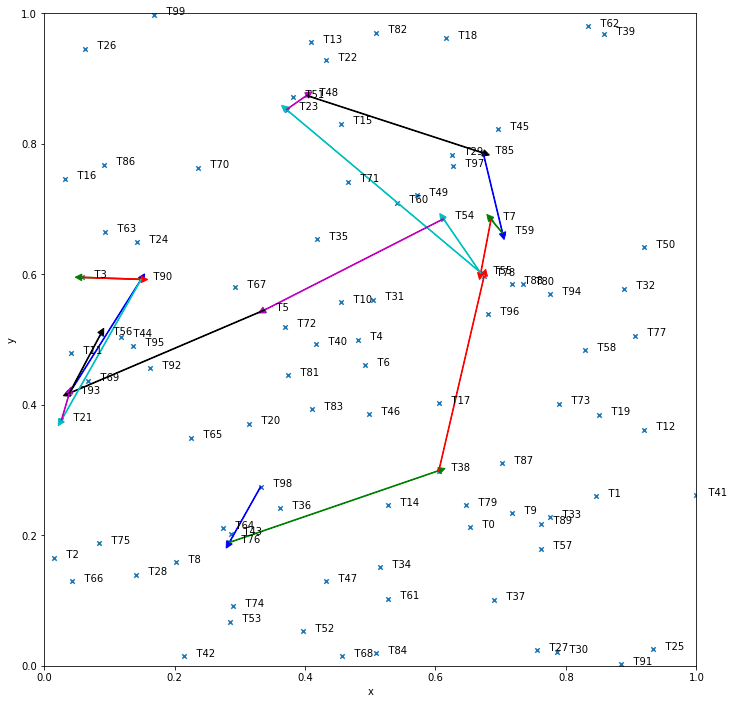

In [20]:
from itertools import cycle

df_towers = pd.DataFrame(towers, columns=['x', 'y'])
ax = df_towers.plot.scatter(x='x', y='y', ylim=(0,1), xlim=(0, 1), figsize=(12, 12), marker='x')

for i in range(len(towers)):
    ax.annotate(f'    T{i}', (df_towers.iloc[i].x, df_towers.iloc[i].y))

cycol = cycle('bgrcmk')

trace = random_traces[1]
for i in range(CYCLES - 1):
    if trace[i] == trace[i + 1]:
        print(f'Cycle #{i}: Staying in tower T{trace[i]}')
        continue
    x1, y1 = towers[trace[i]]
    x2, y2 = towers[trace[i + 1]]

    print(f'Cycle #{i}: Switching from T{trace[i]} to T{trace[i + 1]}')
    color = next(cycol)
    ax.arrow(x1, y1, x2 - x1, y2 - y1, head_width=0.01, head_length=0.01, fc=color, ec=color)

plt.gca().set_aspect('equal', adjustable='box')